In [32]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader,TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve, \
precision_recall_curve, auc

from stepbystep.v0 import StepByStep

## Data Generation

In [33]:
X,y=make_moons(n_samples=100, noise=0.3,random_state=0)

# Train validation split
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=13)

* Split is the **first thing** you always do. No Transformation, No preproceessing 

In [34]:
# standardize the features
sc=StandardScaler()
sc.fit(X_train)

X_train=sc.transform(X_train)
X_val=sc.transform(X_val)

## Data Preparation

In [35]:
torch.manual_seed(13)

# Builds tensors from  numpy arrays
X_train_tensor=torch.as_tensor(X_train).float()
y_train_tensor=torch.as_tensor(y_train).float()

X_val_tensor=torch.as_tensor(X_val).float()
y_val_tensor=torch.as_tensor(y_val).float()

# Builds datasets
train_dataset=TensorDataset(X_train_tensor,y_train_tensor)
val_dataset=TensorDataset(X_val_tensor,y_val_tensor)

# Builds dataloaders; Dataloaders are used to feed the data into model in batches
train_loader=DataLoader(dataset=train_dataset,batch_size=16,shuffle=True)
val_loader=DataLoader(dataset=val_dataset,batch_size=16)

## Model  
$z = b + w_1 x_1 + w_2 x_2$     
* z is called logit
* There is no error term in z equation  

$\text{odds ratio(p)}=\frac{p}{q}=\frac{p}{1-p}\text{ratio between probability of success(p) and probability of failure(q).}$
$\text{It quantifies the strength between two events}$


In [36]:
def odd_ratio(prob):
    return prob/(1-prob)

p=0.75
q=1-p
odd_ratio(p),odd_ratio(q)

(3.0, 0.3333333333333333)

/tmp/ipykernel_15487/2549072817.py:14: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(np.linspace(0, 0.99, 100), np.log10(odd_ratio(np.linspace(0, 0.99, 100))), label='log10(p/(1-p))')


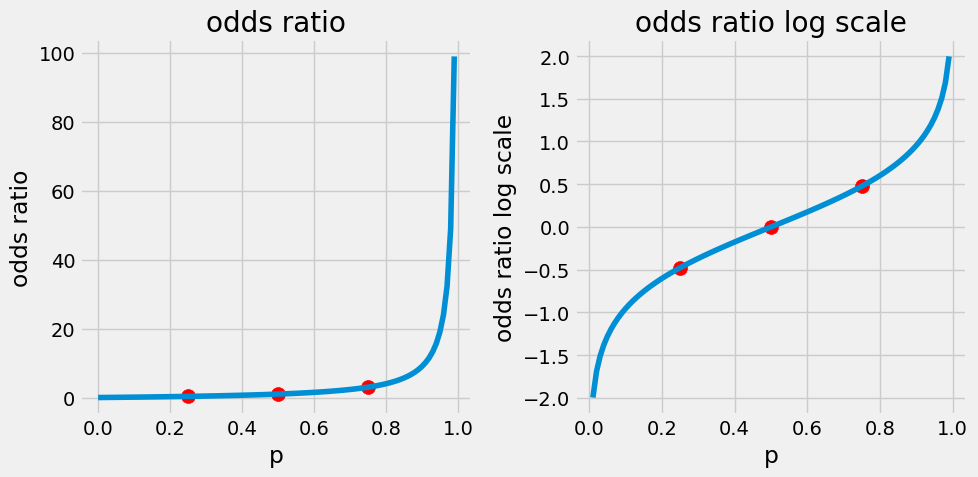

In [37]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first graph

ax[0].plot(np.linspace(0, 0.99, 100), odd_ratio(np.linspace(0, 0.99, 100)), label='p/(1-p)')
ax[0].set_xlabel('p')
ax[0].set_ylabel('odds ratio')
ax[0].set_title('odds ratio')
ax[0].scatter(np.array((0.25,0.5,0.75)),np.array((odd_ratio(0.25),odd_ratio(0.5),odd_ratio(0.75))), color='red', label='Point',s=100)

# plot the second graph
ax[1].plot(np.linspace(0, 0.99, 100), np.log10(odd_ratio(np.linspace(0, 0.99, 100))), label='log10(p/(1-p))')
ax[1].set_xlabel('p')
ax[1].set_ylabel('odds ratio log scale')
ax[1].set_title('odds ratio log scale')
ax[1].scatter(np.array((0.25,0.5,0.75)),np.array((np.log10(odd_ratio(0.25)),np.log10(odd_ratio(0.5)),np.log10(odd_ratio(0.75)))), color='red', label='Point',s=100)

plt.tight_layout()
plt.show()



In [38]:
def log_odds_ratio(p):
    return np.log(odd_ratio(p))

p=0.75
q=1-p

log_odds_ratio(p),log_odds_ratio(q)


(1.0986122886681098, -1.0986122886681098)

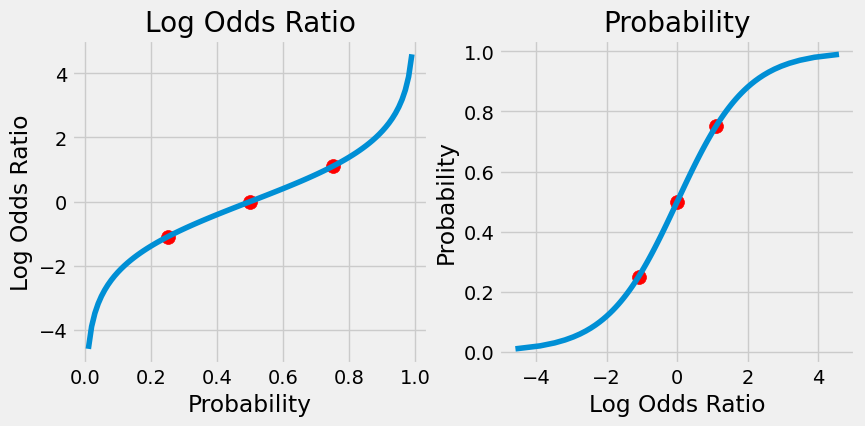

In [39]:
x=np.linspace(0.01,0.99,100)
probs=np.array([0.25,0.5,0.75])
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(9,4))
ax1.plot(x,log_odds_ratio(x))
ax1.set_xlabel('Probability')
ax1.set_title('Log Odds Ratio')
ax1.set_ylabel('Log Odds Ratio')
ax1.scatter(probs,log_odds_ratio(probs),color='red',label='Point',s=100)

ax2.plot(log_odds_ratio(x),x)
ax2.set_ylabel('Probability')
ax2.set_xlabel('Log Odds Ratio')
ax2.set_title('Probability')
ax2.scatter(log_odds_ratio(probs),probs,color='red',label='Point',s=100)

plt.show()

### From logits to probabilities  

Here logits are log odd ratios  

$$

b+w_1x_1+w_2x_2=z=log_e(\frac{p}{1-p}) \\
e^{b+w_1x_1+w_2x_2}=e^z=\frac{p}{1-p} \\
\frac{1-p}{p}=\frac{1}{e^z}\\
\frac{1}{p}-1=e^{-z} \\
\frac{1}{p}=1+e^{-z} \\
\text{Sigmoid function: p}=\frac{1}{1+e^{-z} } \\

$$


In [40]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

p=0.75
q=1-p

sigmoid(log_odds_ratio(p)),sigmoid(log_odds_ratio(q))

(0.75, 0.25)

## sigmoid

In [41]:
print(torch.sigmoid(torch.tensor(log_odds_ratio(p))))
print(torch.sigmoid(torch.tensor(log_odds_ratio(q))))

tensor(0.7500, dtype=torch.float64)
tensor(0.2500, dtype=torch.float64)


In [42]:
nn.Sigmoid()(torch.tensor(log_odds_ratio(p))) # full fledged class inherited from nn.Module.

tensor(0.7500, dtype=torch.float64)

## Logistic Regression

$$
\text logits(z)=z=W^{T} \cdot X \\

z=W^T \cdot X =
\begin{bmatrix}
b&w_1&w_2
\end{bmatrix} \cdot 
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix} \\

z=W^T \cdot X = \text b+w_1x_1+w_2x_2

$$

In [43]:
torch.manual_seed(42)
model1=nn.Sequential()
model1.add_module('linear',nn.Linear(2,1))
model1.add_module('sigmoid',nn.Sigmoid())
model1.state_dict()


OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])),
             ('linear.bias', tensor([-0.1657]))])

$$
\text {Binary Cross Entropy Loss (log loss)} \\
\text {error for a data point in a positive class; } error_i=\log(P(y_i=1)) \\
\text {error for a data point in a negative class; } error_i=1-\log(P(y_i=1)) \\


$$

$$\text {BInary Cross Entropy Loss, the intuitive way} \\
\text {BCE(y)}=-\frac{1}{(N_{pos}+N_{neg})}
\begin{bmatrix}
\sum_{i=1}^{N_{pos}} \log(P(y_i=1))+
\sum_{i=1}^{N_{neg}} \log({1-P(y_i=1)})
\end{bmatrix}
$$

In [44]:
dummy_labels=torch.tensor([1.0,0.0])
dummy_preds=torch.tensor([0.9,0.2])

In [45]:
%%time

# Positive class (labels==1)
positive_pred=dummy_preds[dummy_labels==1]
first_summation=torch.log(positive_pred).sum()

# Negative class (labels==0)
negative_pred=dummy_preds[dummy_labels==0]
second_summation=torch.log(1-negative_pred).sum()

# n_total=n_pos+n_neg
n_total=len(dummy_labels)

loss=-(first_summation+second_summation)/n_total
loss


CPU times: user 860 µs, sys: 969 µs, total: 1.83 ms
Wall time: 1.22 ms


tensor(0.1643)

$$
\text {Binary Cross Entropy Loss; The clever way} \\
\text {The formula computes the loss in a single expression} \\
\text {BCE(y)}=-\frac{1}{N}
\begin{bmatrix}
\sum_{i=1}^{N} y_i\log(P(y_i=1))+(1-y_i)\log(1-P(y_i=1))
\end{bmatrix}
$$

In [46]:
%%time
summation=(torch.log(dummy_preds).mul(dummy_labels)+torch.log(1-dummy_preds).mul(1-dummy_labels)).sum()
loss=-summation/len(dummy_labels)
loss

CPU times: user 1.11 ms, sys: 30 µs, total: 1.14 ms
Wall time: 773 µs


tensor(0.1643)

In [47]:
loss_fn=nn.BCELoss(reduction='mean')
loss_fn

BCELoss()

$\text {Make sure to pass the predictions first and then labels}$

In [48]:
dummy_labels=torch.tensor([1.0,0.0])
dummy_predictions=torch.tensor([0.9,0.2])

# Right loss
right_loss=loss_fn(dummy_predictions,dummy_labels)

# wrong loss
wrong_loss=loss_fn(dummy_labels,dummy_predictions)

print(f"Right loss: {right_loss}\nWrong loss: {wrong_loss}")

Right loss: 0.16425205767154694
Wrong loss: 15.000000953674316


<div style="text-align: center">
<h2>BCEWithLogitLoss</h2>
</div>

$$
\text {This function takes logits as sn argument instead of probabilities} \\
\text {You do not add sigmoid as last layer when using this function} \\
\text {Use Right combination of \textbf{model and loss function}} \\
\text{nn.Sigmoid() as Last layer} \rightarrow \text{nn.BCELoss()} \\
\text{No Sigmoid in Last layer} \rightarrow \text{nn.BCEWithLogitLoss()} \\
$$





In [49]:
loss_fn_logits=nn.BCEWithLogitsLoss(reduction='mean')
loss_fn_logits

BCEWithLogitsLoss()

In [50]:
logit1=log_odds_ratio(0.9)
logit2=log_odds_ratio(0.2)
dummy_labels=torch.tensor([1.0,0.0],dtype=torch.float32)
dummy_logits=torch.tensor([logit1,logit2],dtype=torch.float32)

print(dummy_logits)

tensor([ 2.1972, -1.3863])


In [51]:
loss=loss_fn_logits(dummy_logits,dummy_labels)
loss

tensor(0.1643)

### Imbalanced Dataset

In [52]:
dummy_imb_labels=torch.tensor([1.0,0.0,0.0,0.0])
dummy_imb_logits=torch.tensor([logit1,logit2,logit2,logit2])
                              

$$
\text {pos\_weight}=\frac{\text{\# points in negative class}}{\text{\# points in positive class}}
$$

In [53]:
n_neg=(dummy_imb_labels==0).sum().float()
n_pos=(dummy_imb_labels==1).sum().float()
pos_weight=n_neg/n_pos
pos_weight

tensor(3.)

$\text{Another loss function including pos\_weight}$

In [54]:
# Weighted loss function
loss_fn_imb=nn.BCEWithLogitsLoss(pos_weight=pos_weight,
                                 reduction='mean')

loss=loss_fn_imb(dummy_imb_logits,dummy_imb_labels)
loss

tensor(0.2464)

$\text{PyTorch does nor compute weighted average}$
$$
\text{weighted average}=\frac{pos\_weight \times \sum_{i=1}^{N_{pos}} loss_i+\sum_{i=1}^{N_{neg}} loss_i}{pos\_weight \times N_{pos}+N_{neg}}
$$
$ \text {BCEWithLogitLoss}$

$$
\text {BCEWithLogitLoss}=\frac{pos\_weight \times \sum_{i=1}^{N_{pos}} loss_i+\sum_{i=1}^{N_{neg}} loss_i}{N_{pos}+N_{neg}}
$$

$\text {What if you need Weighted average?}$

In [55]:
loss_fn_imb_sum=nn.BCEWithLogitsLoss(reduction='sum',
                                     pos_weight=pos_weight)
loss=loss_fn_imb_sum(dummy_imb_logits,dummy_imb_labels)
loss=loss/(n_neg+n_pos*pos_weight)
loss

tensor(0.1643)

## Model Configuration

In [56]:
# Model configuration
lr=0.1

torch.manual_seed(42)
model=nn.Sequential()
model.add_module('linear',nn.Linear(2,1))

# Define SGD optimzier
optimizer=optim.SGD(model.parameters(),lr=lr)

# define BCE with logits loss function
loss_fn=nn.BCEWithLogitsLoss()

## Model training

In [57]:
n_epochs=100
sbs=StepByStep(model,loss_fn,optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.train(n_epochs)


  0%|          | 0/100 [00:00<?, ?it/s]

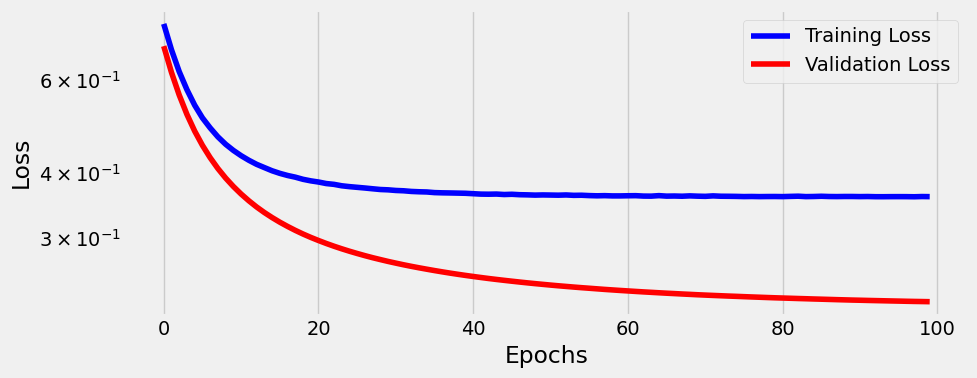

In [58]:
fig=sbs.plot_losses()

In [63]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]])),
             ('linear.bias', tensor([-0.0591]))])

$$
\textbf {logit equation} \\
\text {z}=b + w_1 x_1 + w_2 x_2 \\
\text {z}=-0.0591 + 1.1806 x_1 - 1.8693 x_2
$$

In [65]:
# making predictions
predictions=sbs.predict(X_train_tensor[:4])
predictions

array([[ 0.20345592],
       [ 2.9444451 ],
       [ 3.6933177 ],
       [-1.2334073 ]], dtype=float32)

In [66]:
# making predictions
probabilities=sigmoid(predictions)
probabilities

array([[0.5506892 ],
       [0.9500003 ],
       [0.9757152 ],
       [0.22558564]], dtype=float32)

$$
\text {Probabilities to classes} \\
y = 
\begin{cases} 
1 & \text{if } P(y=1) \geq 0.5 \\
0 & \text{if } P(y=1) < 0.5
\end{cases} \\

y = 
\begin{cases} 
1 & \text{if } \sigma(z) \geq 0.5 \\
0 & \text{if } \sigma(z) < 0.5
\end{cases} \\

y = 
\begin{cases} 
1 & \text{if } z \geq 0 \\
0 & \text{if } z < 0 
\end{cases} \\

$$

In [82]:
(predictions>=0).astype(np.int32)

array([[1],
       [1],
       [1],
       [0]], dtype=int32)

$\text {logit (z) = 0 determines the boundary between positive and negative examples}$